<a href="https://colab.research.google.com/github/GolDRoger69/Drug-Discovery-using-ML/blob/main/Python/PB_project_regressors_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Libraries**

In [1]:
!pip install lazypredict


## **2. Mounting Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

BASE = '/content/drive/MyDrive/Colab Notebooks/data/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **2.1 Loading Essential Files**

In [3]:

import pickle, pandas as pd

# Evaluation metrics & test predictions (optional)
with open(BASE + 'evaluation_results_tuned.pkl','rb') as f:
    eval_res = pickle.load(f)
print("Saved Eval Metrics:", eval_res)

with open(BASE + 'predictions_data_tuned.pkl','rb') as f:
    preds = pickle.load(f)
pred_df = pd.DataFrame(preds)
print("\nSaved Test Predictions:\n", pred_df.head())

# Preprocessing objects & trained model
with open(BASE + 'scaler.pkl','rb')   as f: scaler   = pickle.load(f)
with open(BASE + 'selector.pkl','rb') as f: selector = pickle.load(f)
with open(BASE + 'best_random_forest_model.pkl','rb') as f:
    best_model = pickle.load(f)
print("\nLoaded model, scaler, selector.")


Saved Eval Metrics: {'Best Parameters': {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}, 'R² score': 0.37395919939185374, 'MSE': 0.15329552279578262}

Saved Test Predictions:
        Actual  Predicted
739  4.511026   4.317927
788  4.000000   4.379512
43   4.633204   4.496216
155  4.365624   4.362989
494  4.674484   4.350870

Loaded model, scaler, selector.


## **2.2 Train/Test Split of Data**

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
# 2. Load and preprocess your data (same CSV you trained on)
df = pd.read_csv(BASE + 'bioactivity_data_3class_pIC50_pubchem_fp.csv')
df.fillna(df.mean(), inplace=True)

X = df.drop(columns=['pIC50'])
y = df['pIC50']

# 3. Apply scaling and variance threshold
X_scaled   = scaler.transform(X)
X_selected = selector.transform(X_scaled)

# 4. Train/test split (same seed)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

print(f"Data shapes → X_train: {X_train.shape}, X_test: {X_test.shape}")



Data shapes → X_train: (971, 601), X_test: (243, 601)


## **3. LazyPredict**

In [ ]:
# 5. Run LazyRegressor
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

# 5a. Benchmark on train split
models_train, preds_train = clf.fit(X_train, X_train, Y_train, Y_train)

# 5b. Benchmark on test split
models_test, preds_test   = clf.fit(X_train, X_test,  Y_train, Y_test)

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 971, number of used features: 445
[LightGBM] [Info] Start training from score 4.524325
'tuple' object has no attribute '__name__'
Invalid Regressor(s)


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 971, number of used features: 445
[LightGBM] [Info] Start training from score 4.524325


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# 6. Compute your tuned RF’s metrics on the same test set
y_pred_rf = best_model.predict(X_test)
r2_rf     = r2_score(Y_test, y_pred_rf)
rmse_rf   = np.sqrt(mean_squared_error(Y_test, y_pred_rf))

print(f"Tuned RF → TEST R²: {r2_rf:.4f}, RMSE: {rmse_rf:.4f}")

# 7. Merge your RF into the LazyRegressor table
df_models = models_test.reset_index().rename(columns={'index':'Model'})
my_row = pd.DataFrame([{
    'Model'     : 'Tuned RandomForest',
    'R-Squared' : r2_rf,
    'RMSE'      : rmse_rf,
    'Time Taken': np.nan
}], columns=df_models.columns)

comparison = pd.concat([df_models, my_row], ignore_index=True)


Tuned RF → TEST R²: 0.3740, RMSE: 0.3915


In [ ]:

# 7. Merge your RF into the LazyRegressor table
df_models = models_test.reset_index().rename(columns={'index':'Model'})
my_row = pd.DataFrame([{
    'Model'     : 'Tuned RandomForest',
    'R-Squared' : r2_rf,
    'RMSE'      : rmse_rf,
    'Time Taken': np.nan
}], columns=df_models.columns)

# comparison = pd.concat([df_models, my_row], ignore_index=True)

# # 8. Print full comparison
# pd.set_option('display.max_rows', None)
# print("\n=== LazyRegressor vs. Tuned RF on Test Split ===")
# print(comparison)
lazy_vs_tuned = pd.concat([df_models, my_row], ignore_index=True)

In [ ]:
preds_test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,1574399534794129759088410624000.00,-2335576169384679894777245728768.00,756241374155062.00,0.53
SGDRegressor,74422543957058912.00,-110403691242083264.00,164420215.58,0.08
KernelRidge,58.92,-84.93,4.59,0.16
GaussianProcessRegressor,50.43,-72.32,4.24,2.32
RANSACRegressor,11.72,-14.90,1.97,20.76
MLPRegressor,2.90,-1.82,0.83,4.18
TransformedTargetRegressor,2.33,-0.98,0.70,0.22
LinearRegression,2.33,-0.98,0.70,0.46
LinearSVR,2.26,-0.87,0.68,2.41


In [ ]:
lazy_vs_tuned

,Model,Adjusted R-Squared,R-Squared,RMSE,Time Taken
0,Lars,1574399534794129759088410624000.00,-2335576169384679894777245728768.00,756241374155062.00,0.53
1,SGDRegressor,74422543957058912.00,-110403691242083264.00,164420215.58,0.08
2,KernelRidge,58.92,-84.93,4.59,0.16
3,GaussianProcessRegressor,50.43,-72.32,4.24,2.32
4,RANSACRegressor,11.72,-14.90,1.97,20.76
5,MLPRegressor,2.90,-1.82,0.83,4.18
6,TransformedTargetRegressor,2.33,-0.98,0.70,0.22
7,LinearRegression,2.33,-0.98,0.70,0.46
8,LinearSVR,2.26,-0.87,0.68,2.41
9,PassiveAggressiveRegressor,1.93,-0.39,0.58,0.13


In [ ]:
models_test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,1574399534794129759088410624000.00,-2335576169384679894777245728768.00,756241374155062.00,0.53
SGDRegressor,74422543957058912.00,-110403691242083264.00,164420215.58,0.08
KernelRidge,58.92,-84.93,4.59,0.16
GaussianProcessRegressor,50.43,-72.32,4.24,2.32
RANSACRegressor,11.72,-14.90,1.97,20.76
MLPRegressor,2.90,-1.82,0.83,4.18
TransformedTargetRegressor,2.33,-0.98,0.70,0.22
LinearRegression,2.33,-0.98,0.70,0.46
LinearSVR,2.26,-0.87,0.68,2.41


In [ ]:
models_train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreeRegressor,0.89,0.96,0.11,0.19
DecisionTreeRegressor,0.89,0.96,0.11,0.27
ExtraTreesRegressor,0.89,0.96,0.11,12.89
GaussianProcessRegressor,0.89,0.96,0.11,3.17
XGBRegressor,0.85,0.94,0.13,0.47
MLPRegressor,0.84,0.94,0.14,6.92
RandomForestRegressor,0.69,0.88,0.19,7.24
BaggingRegressor,0.59,0.85,0.22,0.92
LGBMRegressor,0.55,0.83,0.23,0.34


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Generate a rainbow-style palette (using cubehelix with custom hue start)
rainbow_palette = sns.color_palette("hsv", len(lazy_vs_tuned))  # hsv gives vivid rainbow colors


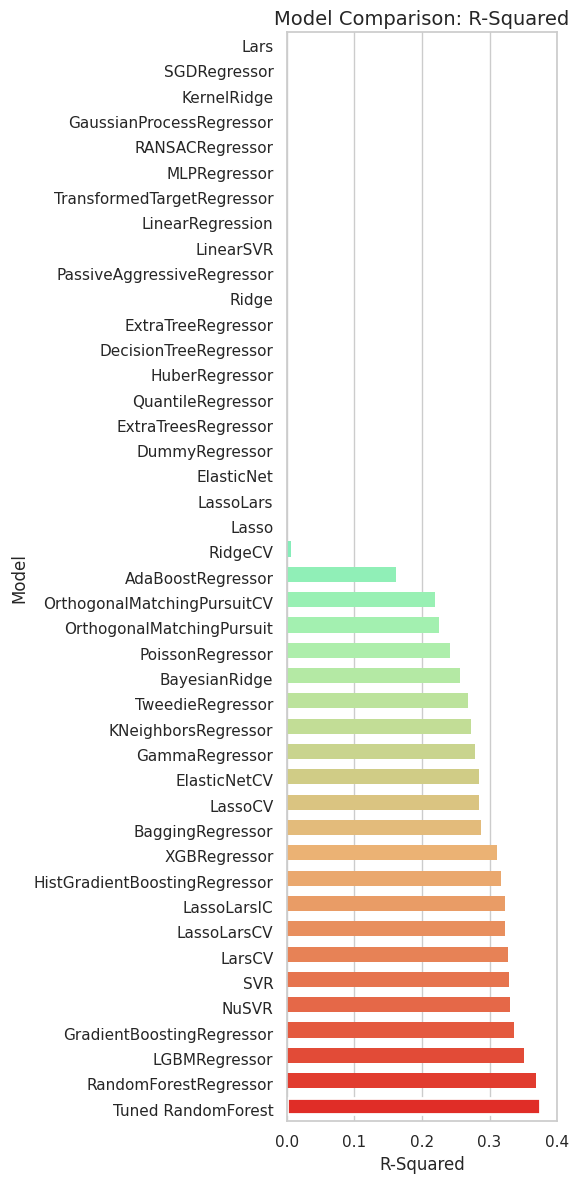

In [ ]:

plt.figure(figsize=(6, 12))
sns.set(style="whitegrid")

ax = sns.barplot(data=lazy_vs_tuned, y="Model", x="R-Squared", palette=rainbow)

# Reduce bar height and highlight the tuned model
for i, bar in enumerate(ax.patches):
    bar.set_height(0.6)
    model_name = lazy_vs_tuned.iloc[i]["Model"]
    if model_name == "Tuned RandomForest":
        bar.set_linewidth(2)
        # bar.set_edgecolor("red")
    else:
        bar.set_linewidth(0)

plt.title("Model Comparison: R-Squared", fontsize=14)
plt.xlim(0, 0.4)
plt.tight_layout()
plt.show()


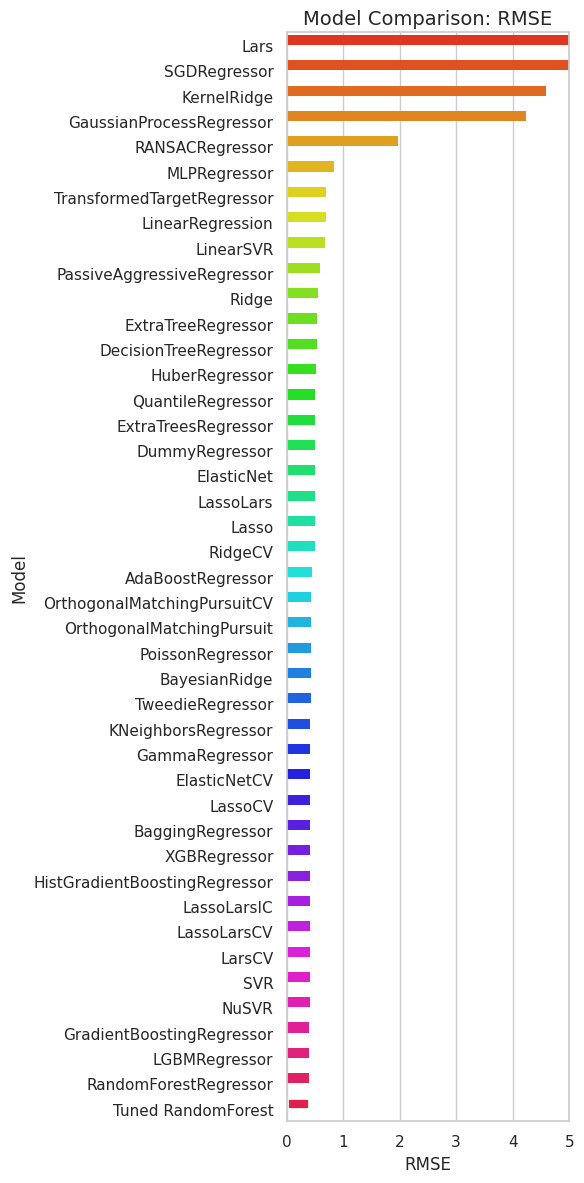

In [ ]:
plt.figure(figsize=(6, 12))
sns.set(style="whitegrid")

ax = sns.barplot(data=lazy_vs_tuned, y="Model", x="RMSE", palette=rainbow_palette)

for i, bar in enumerate(ax.patches):
    bar.set_height(0.4)
    model_name = lazy_vs_tuned.iloc[i]["Model"]
    if model_name == "Tuned RandomForest":
        bar.set_linewidth(2)
        # bar.set_edgecolor("red")
    else:
        bar.set_linewidth(0)

plt.title("Model Comparison: RMSE", fontsize=14)
plt.xlim(0, 5)
plt.tight_layout()
plt.show()


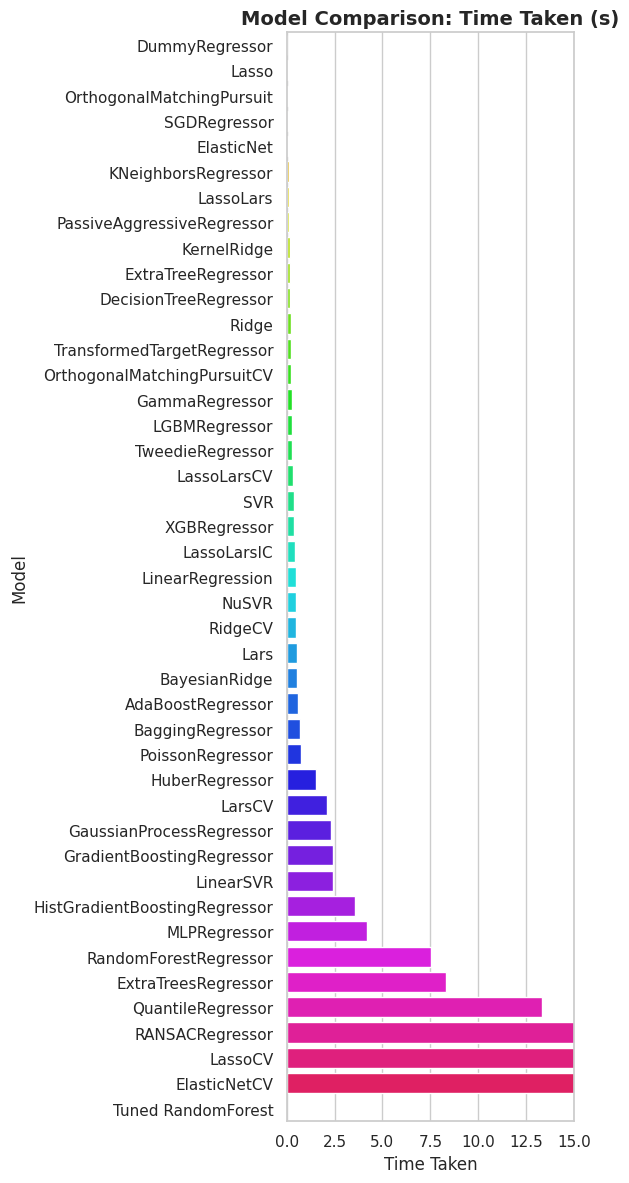

In [ ]:
plt.figure(figsize=(6, 12))
sns.set(style="whitegrid")
ax = sns.barplot(
    data=lazy_vs_tuned.sort_values("Time Taken", na_position='last'),
    y="Model", x="Time Taken", palette=rainbow_palette
)
ax.set_title("Model Comparison: Time Taken (s)", fontsize=14, fontweight='bold')
plt.xlim(0, 15)
plt.tight_layout()
plt.show()